<a href="https://colab.research.google.com/github/MergeGrapes/Hands-On-ML2/blob/master/Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 분류

# MNIST
머신러닝의 hello world 데이터 셋..10만개의 이미지로 구성되어있음!
openml에서 다운로드 받아야 한다.
픽셀 데이터이며 정수 값이 들어가 있다.

In [1]:
# mnist dataset openml에서 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)        # as_frame = True (데이터 프레임으로 받겠다~ 지금은 아니니 frame = null)
                                                                              #mnist_784라는 아이디를 부여하며 버전1에 해당하는 것을 받겠다.

# keys 조회 (딕셔너리 스타일로 값을 가진 bunch 스타일 객체)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

사이킷 런에서 읽어들인 데이터 셋들은 비슷한 딕셔너리 구조를 가지고 있다.

* 데이터셋을 설명하는 DESCR키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 DATA 키
* 레이블배열을 담은 TARGET 키

In [2]:
mnist["url"]   # 얘 데려온 url

'https://www.openml.org/d/554'

In [3]:
# 배열 살피기 (2차원)
# X와 y에 data와 target값을 받고 X먼저 조회하기

X, y = mnist["data"], mnist["target"]
X.shape

# 행이 70000개고 열이 784개이다~
# 70000개 샘플이 있고 784개 특성이 있구나~(픽셀이 28*28이라..)

(70000, 784)

In [4]:
y.shape

# 이미지가 70000개 있고 이미지의 특성이 784개 있다는 뜻이다.
# 이미지의 픽셀이 28*28픽셀이기 때문이다.

(70000,)

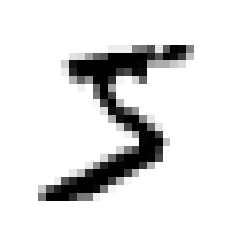

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]          # 이미지 한 놈을 some_digit에다 넣어주고...(얘가 numpy인데 바꿔줘야지)
some_digit_image = some_digit.reshape(28, 28)     # 샘플의 특성 벡터를 추출해 28*28 배열로 크기 바꾸기

plt.imshow(some_digit_image, cmap = "binary")     # imshow로 조회하기  # binary(보기 편하게 흑백값 반전)
plt.axis("off")
plt.show()

In [6]:
y[0]

# y이 첫번째 레이블(클래스 확인~)
# 실제 데이터 특성도 5 (레이블)

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)  # 정수 배열로 바꿔서 확인할 것이다

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt. imshow(image, cmap=mpl.cm.binary,
               interpolation="nearest")
    plt. axis("off")

In [9]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size*n_empty)))
    for row in range(n_rows) : 
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

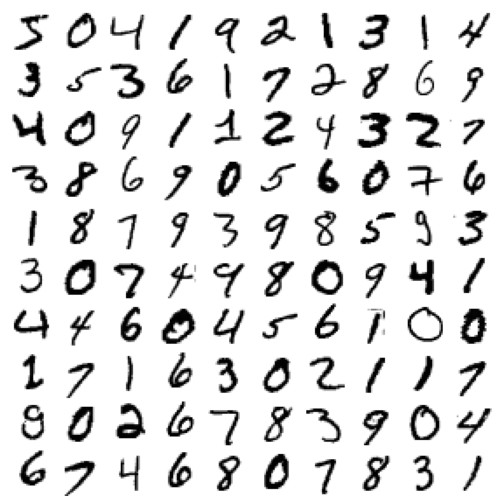

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [11]:
y[0]  # integer로 잘 바뀌었군~

5

In [12]:
# 훈련셋 확인해서 스플릿~
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 훈련 세트는 이미 섞여 있기 때문에 모든 교차 검증 폴드가 비슷해진다.
# 어떤 학습 알고리즘은 훈련 샘플 순서에 민감해서 많은 비슷한 샘플이 있을 경우 성능이 나빠진다.
# 데이터셋을 섞으면 이런 문제를 방지할 수 있다.
# 그러나 주식 가격 같은 시계열 데이터는 오히려 섞지 않는 것이 나을 수 있다.

#SGDClassifier, SGDRegressor는 기본적으로 에포크(max_iter)마다 데이터를 다시 섞는다.

# 3.2 이진 분류기 훈련
숫자 '5' 가 있다면 '5-감지기'와 '5 아님' 두 개의 클래스를 구분할 수 있는 것이 이진 분류기의 예이다. 

In [13]:
y_train_5 = (y_train == 5)        # 5만 true이고 나머지는 false (이진분류기 만들기~)
y_test_5 = (y_test == 5)

## SGDClassifier
SGD : 확률적 경사 하강법 (Stochastic Gradient Descent)
- 매우 큰 데이터셋도 효율적으로 처리한다.
- 한번에 하나씩 훈련 샘플을 독립적으로 처리한다.
- 온라인 학습에 잘 들어맞는다.

In [14]:
# SGDClassifier 만들고 적용시켜보기
# 이거 쓰면서 여러가지 분류 모델 만들 수 있땅

from sklearn. linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)       # sgd_clf는 SGDClassifier로 만들고
sgd_clf.fit(X_train, y_train_5)                              # .fit 적용해서 X_train, y_train_5를 사용하는 함수로 만들어줘

# 아까 만든 분류기 집어넣었다
# SGDClassifier는 훈련하는데에 무작위성을 사용한다. 동일한 결과를 재현하고 싶다면 random_state매개변수를 지정한다.

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

# 아까 some_digit는 1차원 배열인데 기본적으로 함수가 2차원 배열로 돌아가므로 [리스트] 로 감싸준다.
# 아까 샘플 넣고 돌리면 true라고 잘 예측 함
# true 값이 나오므로 분류기는 이 값이 5를 나타낸다고 추측한 것!

array([ True])

## 퍼셉트론
![perceptron_1](perceptron_1.png)

퍼셉트론(perceptron)은 가장 오래되고 단순한 형태의 판별함수기반 분류모형 중 하나이다.
퍼셉트론은 입력  x=(1,x1,⋯,xm) 에 대해 1 또는 -1의 값을 가지는  y 를 출력하는 비선형 함수이다. 1을 포함하는 입력 요소  xi 에 대해 가중치  wi 를 곱한 값  a=wTx 을 활성화값(activations)이라고 하며 이 값이 판별함수의 역할을 한다.

a=wTx

판별 함수 값이 활성화함수(activation function) h(a)를 지나면 분류 결과를 나타내는 출력 y^가 생성된다.

y^=h(wTx)

퍼셉트론의 활성화 함수는 부호함수(sign function) 또는 단위계단함수(Heaviside step function)라고 부르는 함수이다.

h(a)={(−1,1),(a<0,a≥0)


## 퍼셉트론 손실함수

x, y = 독립변수, 종속변수
w = 가중치(예측 오차 최소화하는)
L = 전체 예측 오차 (가중치값에 따라 달라지는)

다음과 같이  N 개의 학습용 데이터가 있다고 하자.

(x1,y1),(x2,y2),…,(xi,yi),…,(xN,yN)
 
퍼셉트론은 독립변수  x 로부터 종속변수  y 를 예측하는 예측 모형이므로 모든 학습 데이터에 대해 예측 오차를 최소화하는 가중치  w 를 계산해야 한다. 가중치  w 에 따라 달라지는 전체 예측 오차  L 는  i 번째 개별 데이터에 대한 손실함수  Li(y^i,yi) 의 합으로 표현할 수 있다.

![L](L.png)

손실  Li(yi,y^i) 는 실제값  y 와 예측값  y^ 의 차이를 나타내는 함수이다. 회귀 분석에서는  L(y^,y)=−(y−y^)2 과 같은 손실함수를 많이 사용하였지만 퍼셉트론의 경우에는 다음과 같은 손실 함수를 사용한다. 이를 제로-원 손실함수(zero-one loss function)이라고 한다.

![zero_one_loss_fun](zero_one_loss_fun.png)

제로-원 손실함수  Li 은  y^ 과  y 가 같으면 0이고 다르면 1이다. 다음처럼 서술할 수도 있다.

![zero_one_loss_fun2](zero_one_loss_fun2.png)

그런데 제로-원 손실함수를 쓰면  y^(x) 가  x 에 대한 계단형 함수이므로 대부분의 영역에서 기울기가 0이 되어 미분값으로부터 최소점의 위치를 구할 수 없다. 따라서 퍼셉트론에서는  y^  대신 활성화값  wTx 를 손실함수로 사용한다.

![zero_one_loss_fun3](zero_one_loss_fun3.png)

이를 퍼셉트론 손실함수(perceptron loss function) 또는 0-힌지 손실함수(zero-hinge loss function)라고 한다. 여기에서 손실값은 오분류된 표본에 대해서만 계산한다는 점에 주의하라. 이 때는  y 와  sgn(y^) 값이 다르면 오분류된 것이다.

![zero_one_loss_fun4.png](zero_one_loss_fun4.png)

https://datascienceschool.net/view-notebook/342b8e2ecf7a4911a727e6fe97f4ab6b/

퍼셉트론 손실함수는 다음처럼 표기할 수도 있다.

![perloss.png](perloss.png)


## SGD

SGD(Stochastic Gradient Descent) 방법은 손실함수 자체가 아니라 손실함수의 기댓값을 최소하는 방법이다.


# 3.3 성능 측정

분류기 평가는 회귀모델보다 어렵다. 사용할 수 있는 성능 지표가 많으니 여유롭게 둘러보자

## 3.3.1 교차 검증을 사용한 정확도 측정

### 교차 검증 구현
사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다. 이때는 교차 검증 기능을 직접 구현하면 된다. 다음 코드는 사이킷 런의 cross_val_score() 함수와 비슷한 작업을 수행하고 동일한 결과를 출력한다. 잘 보자

In [17]:
from sklearn.model_selection import StratifiedKFold  # 이친구는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다. 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)  # 훈련 세트를 3개의 폴드로 나누자
# cross_val_score(gd_clf, X_train, y_train_5, cv=skfolds)  # 이렇게 하면 skf사용해서 3겹 교차검증 사용 가능

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [18]:
# cross_val_score() 함수로 폴드 3개인 k겹 교차 검증 사용해 SGDClassifier 모델 평가하기 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")   #accuracy 정확도를 보겠다고 한건데 디폴트값


# 다 95%가 넘는 점수 ㄷㄷ 정확도가 95%라는 소리다
# 근데 전체 샘플 중 5가 아닌게 90%이므로 해당 점수는 딱히 좋은게 아니다

array([0.95035, 0.96035, 0.9604 ])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#정확도만으로 모델의 좋고 나쁨을 파악하기는 어렵다(불균형한 데이터셋)
#5가 너무 적으니깐..
# 무조건 5 아님' 으로 예측하면 90% 이상의 정확도가 나온다는 이유

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차행렬
클래스A의 샘플이 클래스 B로 잘못 분류된 횟수를 세는 방법이다.

숫자 5가 3으로 잘못 분류된 횟수를 알고 싶다면 오차 행렬의 5행 3열을 조회하는 방식

오차 행렬을 만들려면..
* 실제 타깃과 비교할 수 있도록 예측값을 먼저 만든다
* 테스트 세트로 예측 만들 수 있어도 여기서 사용하지 않는다
* cross_val_predict() 함수는 사용 가능하다

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

##### cross_val_predict
이 함수는  cross_val_score함수처럼 k겹 교차검증을 진행하나 평가 점수를 반환하지는 않고 각 테스트 폴드의 예측을 반환한다.  훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 되는 것.(훈련 동안 보지 못한 데이터에 대해 예측)

In [22]:
# confusion_matrix() 함수를 이용해 오차 행렬을 만들자 타깃클래스(y_train_5)와 예측 클래스(y_train_pred) 넣기

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다. 이 행렬의 첫 행은 '5가 아닌 숫자를 53892개를 5가 아닌 것으로 정확히 분류했고, 687개는 5가 아닌데 5라고 잘못 분류했다.

두 번째 행은 5인데 5아님으로 1891개로 잘못 분류했고, 나머지 3530개를 5인데 정확히 5라고 분류했다.

(찐음, 짭양)
(짭음, 찐양)

In [23]:
y_train_perfect_predictions = y_train_5      #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 정밀도란?
TP(찐양)/(TP+FP), 즉 양성이라고 '예측한' 놈들 중에 진짜 양성이었던 친구들의 비율 가지고 정밀도라~하는 것이다..

#### 재현율이란?
TP/(TP+FN), 즉 진짜양성이랑 거짓음성(그니까 실제로 양성인) 친구들  = '실제로'값이 양성인 애들 중에서 찐으로 판명난 비율을 가지고 재현율이라~한다.


## 3.3.3 정밀도와 재현율
위의 친구들을 토대로 나가보자~ 이말이야~

In [24]:
# 정밀도
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)    #3530/(3530+687) 정밀도! 

0.8370879772350012

In [25]:
# 재현율

recall_score(y_train_5, y_train_pred)        #3530/(3530+1892)

# 아까 90퍼라 그러더니 이거 뭐냐
# 여튼 정밀도와 재현율 2개의 지표가 있는데 F1이라는 다른 것도 있다.

0.6511713705958311

### F1 점수~

TP / [TP+{(FN+FP)/2}] 라고 계산해도 되고,

2(정밀도 * 재현율) / (정밀도+재현율) 해도 된다

In [26]:
# F1점수

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

안타깝게도 정밀도와 재현율을 모두 높일 수는 없다..이런걸 정밀도/재현율 트레이트 오프라고 한다

## 3.3.4 정밀도/재현율 트레이드 오프

SGDClassifier, 이 분류기는 결정함수를 사용해서 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크다면, 샘플은 양성 클래스에 할당하고, 임곗값보다 크지 않다면 음성 클래스에 할당한다.

사이킷 런에서 임곗값을 직접 지정할 수는 없지만, 예측에 사용한 점수는 또 확인할 수 있다!

분휴기의 predict() 대신 decision_function()메서드를 호출해서 각 샘플의 점수를 얻어보자. 그리고 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있따.

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# 아까 수가 2000이 넘는데 양수지? 0보다 크니까 true값이 나왔다
# 8000으로 높이면 false 나오지 뭐

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# 당연히 8000이면 false 나오지..^^;;
# 임곗값을 높이면 재현율이 줄어드는거 보이니
# 적당한 임곗값은 어떻게 설정할까-> cross_val_predict로 모든 샘플 점수 구하기

array([False])

In [30]:
# cross_val_predict 로 모든 샘플 점수 구하기
# 이번엔, 예측결과가 아니라 결정 점수를 반환하도록!!

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

# 이 점수로 precision_recall_curve() 
# 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다규!

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds, = precision_recall_curve(y_train_5, y_scores)

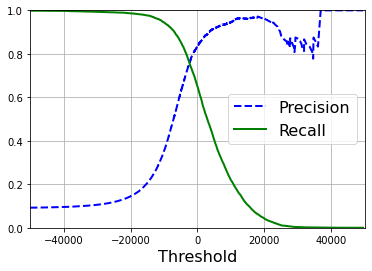

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
     # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

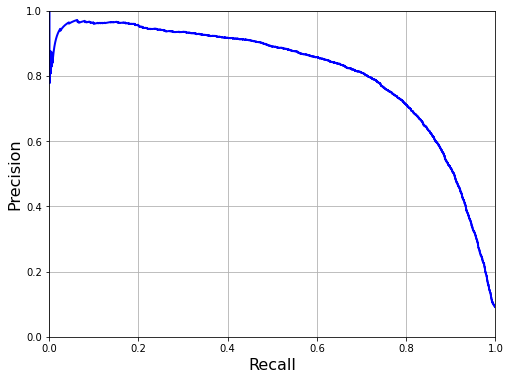

In [34]:
# 정밀도 재현율만 뽑는 곡선

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# from sklearn.metrics import average_precision_score
# average_precision_score(y_train_5, y_scores)

In [35]:
#argmax() 최댓값의 첫 번째 인덱스 반환
# 90보다 큰 정밀도일 때, 인덱스값을 얻고, thredshold에서의 임곘값을 찾자능

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

# 이 점수면 90퍼 이상이구나아..재현율은 떨어지겠지만..^^

3370.0194991439557

In [36]:
# 훈련 세트에 대한 예측

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

ROC receiver operating chracteristic 곡선도 이진 분류에서 널리 사용하는 도구다. 정밀도/재현율 곡선과 매우 비슷하나, ROC곡선은 정밀도에 대한 재현율 곡선이 아니고!! 

거짓양성비율(FPR 짭양비) 에 대한 진짜양성비율(TPR찐양비) 의 곡선이다. (재현율)

TNR = 특이도

ROC = 민감도(재현율) 에 대한 1-특이도 그래프

In [39]:
# roc_curve 함수 사용해 임곗값에서 TPR, FPR 값 계산

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

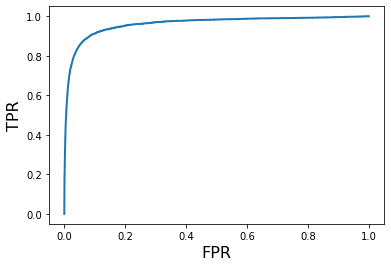

In [40]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plt=([0,1], [0,1], 'k--')
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
plot_roc_curve(fpr, tpr)
plt.show()

좋은 곡선은 우측상향 대각선에서 최대한 멀리 떨어져 있는 친구이다.
찐양율이 올라감에 따라 짭양율도 같이 증가를 해야 말이 맞는 것..

위 그래프의 곡선 아래 면적(AUC)을 측정하면 분류기들을 비교할 수 있다.

완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤분류기는 0.5이다.

사이킷런은 이 함수도 제공한다.


In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### 잠깐만~

roc 곡선이 정밀도/재현율 곡선과 비슷하니까 뭘 사용해야 할지 모르겠다. 일반적으로는..

- 양성클래스가 드물거나 거짓음성(짭음)보다 거짓양성(짭양) 이 더 중요하면 PR
- 아니면 ROC 쓴다.


In [42]:
from sklearn.ensemble import RandomForestClassifier

# predict_proba 메소드는 샘플이 행, 클래스가 열, 예측에 대한 확률값 제공
# 샘플이 주어진 클래스에 속활 확률을 담을 배열 반환
# roc_curve() 함수는 레이블과 점수를 기대...근데 점수 대신 클래스 확률 전달 가능

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method="predict_proba")

In [43]:
# 양성 클래스 확률을 점수로 사용해보자~

y_scores_forest = y_probas_forest[:, 1]      # 양성 클래스에 대한 확률 점수로 써라!, 
# (행=샘플 개수) 1번째 열은 음성 클래스 확률, 2 번째 열은 양성클래스 확률
# 양성클래스 확률만 있으면 되니까 인덱스 1
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

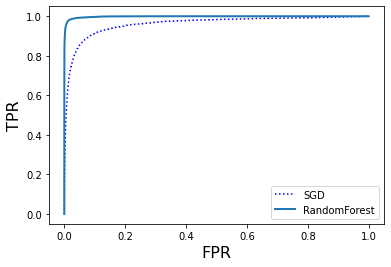

In [44]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")     # 우측 하단에 뭐가 뭔지 표시
plt.show()

# 랜덤포레스트 분류기가 더 낫구먼
# 헷헷

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

# 점수도 좋구만!

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest) # 정밀도

In [ ]:
recall_score(y_train_5, y_train_pred_forest) # 재현율

# 3.4 다중 분류

이진 분류가 두 개의 클래스를 구분한다구? 다중 분류기는 둘 이상의 클래스를 구별한다!

일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있다. 다른 것은 이진 분류만 가능하지만..

하지만 이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법도 많다.

* OvR(OvA): n개의 모델 훈련, liblinear를 사용하는 LinearSVC/LogisticRegression(solver='liblinear') 클래스,
이렇게 이진 분류 여러개를 만들어서 활용할 때, 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선정하면 된다. 이를 OvR전략이라고 한다. (One versus the Rest) (OvA)

* OvO: n(n-1)/2개 푼련, libsvm을 사용하는 SVC 클래스.
또 다른 전략은 0과1 구별, 0과2 구별, 1과 2 구별 같이 각 숫자 조합마다 이진 분류기를 훈련시킬 수 도 있다. 이를 OvO라고 한다. 클래스가 n개 있다고 치면 n(n+1)/2 개가 필요하다.

* Multinomial: SGDClassifier, LogisticRegression(solver!='liblinear'), RandomForestClassifier
다중 클래스 분류 작업에 이진 분류 알고리즘 선택하면, 사이킷런이 알고리즘 따라 자동으로 OvR, OvO 실행한다. 

In [52]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])       # y_train
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
# decision_function() 샘플당 10개의 점수 반환, 클래스 별 하나씩
# 가장 높은 점수가 클래스 5에 해당하는 것
# 클래스마다 결정함수값이 출력, 인덱스 5가 가장 높은 점수이므로 5구나..하는 것

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [54]:
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]   # 인덱스랑 값이 같고, 인덱스만 뽑아서 쓸 수 있는. 인덱스 5의 값은 5다 라는게 결과임

5

분류기가 훈련될 때 classes_속성에 타깃 클래스의 리스트를 값으로 정렬해 저장한다. 위 예제에서는 classes_배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같다. 근데 이런 경우는 드물다.

In [56]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf =  OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

# 강제로 OvR 방식을 쓰게끔 하는 클래스, OneVsRestClassifier
# OneVsOneClassifier는 OvO 쓰게 하는 클래스

array([5], dtype=uint8)

In [57]:
len(ovr_clf.estimators_)  # 이 속성에는 만든 분류기 모델 수를 보여준다. 레이블이 10개라서 가각 1개씩 훈련

10

In [59]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [60]:
# decision_function() 은 클래스(레이블)마다 열 개의 결정 함수 값을 반환한다. (10개의 값이 출력 되겠지...)
# 인덱스 3이 높다고 나오는데 원래 5 간 높아야 한다...뭐징..

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [63]:
# 3개의 폴드로 나눠라. 하나=검증, 둘=훈련 검증세트 계산! 이렇게 총 3번 해라
# cross_validate() 메소드가 추가! : 훈련 시간이 단축, 필드 검증에서 스코어 테스트하는 시간이 리턴!

# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")   # 원래 있던 친구는 얘
from sklearn.model_selection import cross_validate
cross_validate(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

{'fit_time': array([117.40838313,  96.84333062,  95.83895564]),
 'score_time': array([0.08325243, 0.05331612, 0.05944586]),
 'test_score': array([0.87365, 0.85835, 0.8689 ])}

In [66]:
# 2장에서 쓴 친구, StandardScaler, 점수가 더 좋게 나오는 친구
# 왜냐, SGDClassifier는 경사 하강법을 쓰며, 특성 간의 거리, Scale에 민감하게 반응한다. (이런 모델이 다 그래)
# 특성 간의 값을 가지고 거리를 계산하므로 특성의 Scale을 서로 맞춰야 한다
# 안그러면 특성에 편중되어 알고리즘이 수행되겠지..
# 랜덤포레스트는 거리에 전혀 반응하지 않으므로 스케일링 안하고 해도 무방하다.

from sklearn.preprocessing import StandardScaler



In [67]:
scaler = StandardScaler()


In [68]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


In [69]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: ignored

# 3.5 에러 분석

1. 오차 행렬 살펴보기
cross_val_predict() 함수를 사용해 예측을 만들고, confusion_matrix() 함수를 호출한다.

In [72]:
# 다중분류의 경우의 오차 행렬
# 타깃값(y_train)과 예측 값(y_train_pred) 두개를 넣어 conf_mx를 리턴받으면 된다.

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)



# 이진 분류와 마찬가지로 우측 하향 대각선 기준, 왼쪽(밑으로 갈 수록 값이 옆으로 많아짐)이 진짜일 경우,
# 오른쪽(옆으로 갈 수록 값이 밑으로 많아짐)이 가짜일 경우이다.

In [73]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [74]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [75]:
# 매트릭스로 보면 좀 더 편리하게 볼 때가 있다.
# 이미지가 우측 하향 대각선이므로(주대각선) 대부분의 이미지가 올바르게 분류된 것이다.

def plot_confusion_matrix(matrix):
  """If you prefer color and a colorbar"""
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  cax = ax.matshow(matrix)
  fig.colorbar(cax)

NameError: ignored

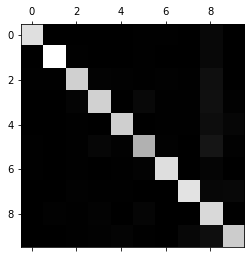

In [76]:
plt.matshow(conf_mx, cmap=plt.cm.gray)  
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

# gray로 설정: 배열에서 가장 큰 값은 흰 색, 작은 값은 검은색으로 그려진다.
# 5가 좀 어두워보이는데, 데이터셋에 5의 이미지가 적거나, 분류기가 숫자 5를 다른 수처럼 잘 분류 못한다는 뜻
# 두개 다 확인해 봐야하는 부분...

In [80]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 각 행의 값을 더해줘, 그걸 norm_conf_mx에다가 나누셈
norm_conf_mx = conf_mx/row_sums    # 비율

NameError: ignored

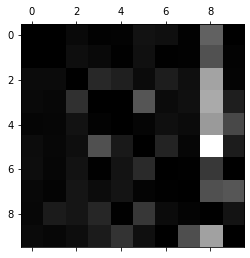

In [81]:
# 8로 잘못 생각한게 되게 많은...
# 진짜 3인 수를 5로 착각
# 진짜 5를 3으로 착각
# 3과 5는 자주 혼돈이 되는 이미지라는 것을 확인가능

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

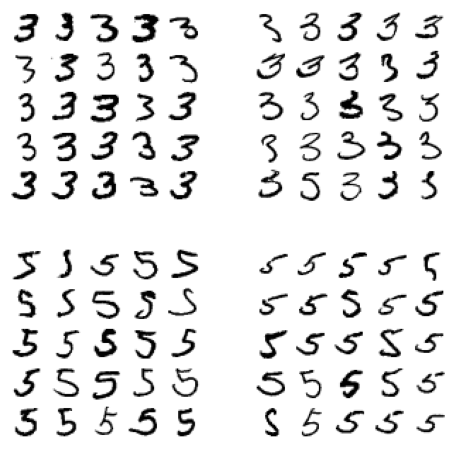

In [84]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

# 좌측 상단 3을 잘 분류
# 우측 상단 3을 5로 잘못 분류
# 좌측 하단 5를 3으로 잘못 분류
# 우측 하단 5를 잘 분류

# 3.6 다중 레이블 분류
출력하는 레이블이 하나가 아니라 여러개일 경우를 다중 레이블 분류라고 한다.

지금까지는 각 샘플이 하나의 클래스에만 할당되었으나, 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음.

ex) 얼굴 인식 분류기..같은 사진에 여러 사람이 나온다.

K 최근접, 결정트리 기반 모델이 다중 분류를 지원한다.

In [87]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)          # 타깃 값이 7보다 큰 것인지?
y_train_odd = (y_train % 2 == 1)      # 타깃 값이 홀수인지..?  이 두개를 npc메소드로 열방향 합침 -> y_multilabel
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [89]:
knn_clf.predict([some_digit])  # 두 개의 레이블이 나오는 (5니까 잘 예측을 한 것이고)

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 시간 많이 걸림 몇시간씩...
# 두 레이블별로 따로 f1을 계산하기 위해..평균을 내면 이게 macro

# 'weighted' 는 macro랑 같은데 샘플 수 로 가중
# 'micro' 모든 레이블별로 fntp를 더해서 f1 스코어를 계산

# 3.7 다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것으로, 값을 2개 이상 가질 수 있다.

이미지에서 잡음을 제거하는 시스템을 만들어보자.

In [95]:
noise = np.random.randint(0, 100, (len(X_train), 784))    
# 784개의 레이블이 나오는 것이고, 0부터 255까지의 픽셀 값이 나온다.
X_train_mod = X_train + noise   # X_train에 noise 를 섞었다
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise     # X_test에 noise 를 섞었다

y_train_mod = X_train   # 자기 자신을 타깃으로 두고 훈련 시작
y_test_mod = X_test 

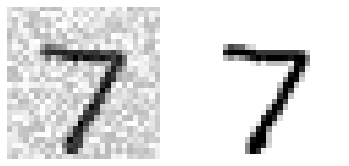

In [92]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

# 왼쪽이 만든 타깃
# 오른쪽이 원본

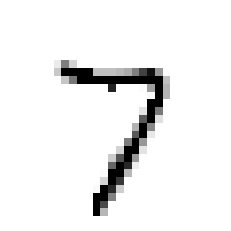

In [96]:
# 분류기를 훈련 시켜 이미지를 깨끗하게 만들어보자

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# 가까운 이웃의 타깃값의 픽셀 평균을 내서 훈련 하는 것.

# 추가 내용
## 더미 분류기
 다른 모델과 비교하거나 베이스 모델로 비교하기 좋으므로 써보자!

In [97]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy = 'stratified')   # prior로 하게 되면 음성클래스의 확률 출력
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

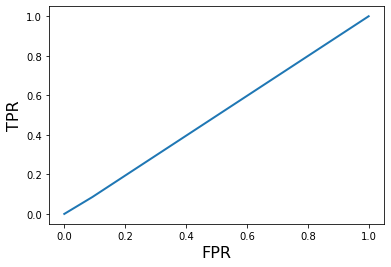

In [98]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN 분류기

In [100]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)  # 가까이 있는 값에 가중치 두는 weight='distance
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [101]:
y_knn_pred = knn_clf.predict(X_test)

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

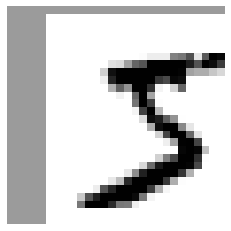

In [103]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new=0):
  return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))


# 이미지를 조금씩 이동하는 메소드
# 오차율, 위치에 덜 민감한 모델을 만들 수 있대

In [105]:
X_train_expanded = [X_train] 
y_train_expanded = [y_train]   # 훈련 세트 전체에다가 원본 세트 넣고
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):    # 원본 세트를 4번 이동하기
  shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
  X_train_expanded.append(shifted_images)
  y_train_expanded.append(y_train)    # 60000개였는데 30만개로 늘어남

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)

X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [106]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
# y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
#accuracy_score(y_test, Y_knn_expanded_pred)

# 점수도 뽑아보고

In [ ]:
# ambiguous_digit = X_test[2589]
# knn_clf.predict_proba([ambiguous_digit])  # 애매한 숫자에 대한 확률값도 출력해보고

In [ ]:
# plot_digit(ambiguous_digit)